*Dilema exploración-explotación*

Supongamos el siguiente problema:
Estamos en una feria y un mago aparece para proponernos un juego.

El juego consiste en lo siguiente:
Delante de nosotros hay una mesa con vasitos de diferentes colores. El mago nos dice que, al elegir un vasito, se nos dará una recompensa, y nuestro trabajo es obtener la mayor cantidad de recompensas posible.

El juego se repite durante 100 rondas.

¿Como procedemos a jugar? ¿Que estrategia usamos?.
Supongamos el caso más sencillo de todos. Los vasitos siempre dan la misma recompensa.
En ese caso podemos simplemente probar todos los vasitos y quedarnos con el mejor de ahi en adelante.

Empecemos definiendo nuestra clase vasitos, con los siguientes atributos color, recompensa y un id.
Además de algunos metodos que nos son de utilidad (por ahora dar recompensa simplemente)

In [263]:
class Vasito:
    def __init__(self, color: str, reward: float, vid: int = None):
        self.color = color
        self.reward = reward
        self.id = vid
        self.history = []

    def dar_recompensa(self) -> float:
        self.history.append(self.reward)
        return self.reward

    def cambiar_recompensa(self, nueva: float):
        self.reward = nueva

    def __repr__(self):
        return f"Vasito(color={self.color}, reward={self.reward})"


Ahora instanciemos 5 vasitos para simular nuestro juego.

In [264]:
vasito_rojo=Vasito("rojo",6,1)
vasito_verde=Vasito("verde",4,2)
vasito_naranja=Vasito("naranja",1,3)
vasito_negro=Vasito("negro",5,4)


Creemos ahora la clase Mesa con la cual simularemos el juego. 
Los atributos son *vasitos* (una lista de objetos de la clase vasitos), *rondas* el número de rondas que jugaremos (100 para iniciar)

In [265]:
class Mesa:
    def __init__(self, vasitos: list, rondas: int = 100):
        self.vasitos = vasitos
        self.rondas = rondas
        self.ronda_actual = 0
        self.historial = []  # guarda (ronda, color, recompensa)

    def jugar(self, eleccion) -> float:
        """Jugar una ronda eligiendo un vasito (por color o por objeto)."""
        if self.ronda_actual >= self.rondas:
            raise ValueError("El juego ya terminó")

        if isinstance(eleccion, str):
            elegido = next((v for v in self.vasitos if v.color == eleccion), None)
        else:  # asumimos que es un objeto Vasito
            elegido = eleccion

        if elegido is None:
            raise ValueError(f"No existe un vasito con identificador '{eleccion}'")

        recompensa = elegido.dar_recompensa()
        self.ronda_actual += 1
        self.historial.append((self.ronda_actual, elegido.color, recompensa))
        return recompensa

    def terminado(self) -> bool:
        """Devuelve True si ya se completaron todas las rondas."""
        return self.ronda_actual >= self.rondas

    def mostrar_historial(self):
        """Imprime el historial de jugadas."""
        for ronda, color, recompensa in self.historial:
            print(f"Ronda {ronda}: {color} → recompensa {recompensa}")

    def colores_disponibles(self):
        """Devuelve la lista de colores de los vasitos en la mesa."""
        return [v.color for v in self.vasitos]

    def __repr__(self):
        return f"Mesa({len(self.vasitos)} vasitos, ronda {self.ronda_actual}/{self.rondas})"



Instanciemos la clase mesa.

In [266]:
vasos=[vasito_rojo,vasito_naranja,vasito_negro,vasito_verde] #creamos la lista de los vasitos.
mesa=Mesa(vasos,rondas=100)
mesa.jugar("negro")
mesa.mostrar_historial()


Ronda 1: negro → recompensa 5


Definamos la  clase estrategía la cual nos permitira simular el juego, con diferentes metodos de toma de decisiones.

Definamos la clase padre Estrategia y luego las clases hijos, Gready, epsilon Gready, valores iniciales optimistas, UCB, Thomson Sampling.

In [267]:
import numpy as np


class Estrategia:
    def decidir(self, mesa: Mesa):
        """Devuelve qué vasito elegir (color o Vasito)."""
        raise NotImplementedError

    def actualizar(self, eleccion, recompensa: float):
        """Permite a la estrategia aprender después de cada jugada."""
        pass




In [268]:
class Greedy(Estrategia):
    def __init__(self):
        self.Q = {}
        self.N = {}

    def _init(self, mesa):
        if not self.Q:
            for color in mesa.colores_disponibles():
                self.Q[color] = 0.0
                self.N[color] = 0

    def decidir(self, mesa: "Mesa") -> str:
        self._init(mesa)
        # elegir el color con mayor Q (si hay empate, toma el primero)
        return max(self.Q, key=self.Q.get)

    def actualizar(self, eleccion, recompensa: float):
        color = eleccion.color if hasattr(eleccion, "color") else eleccion
        self.N[color] += 1
        self.Q[color] += (recompensa - self.Q[color]) / self.N[color]


In [269]:
class EpsilonGreedy(Estrategia):
    def __init__(self, epsilon=0.1, alpha=None, seed=7):
        self.epsilon = epsilon
        self.alpha = alpha
        self.rng = np.random.default_rng(seed)
        self.Q = {}
        self.N = {}


    def _init(self, mesa: "Mesa"):
        if not self.Q:
            for color in mesa.colores_disponibles():
                self.Q[color] = 0.0
                self.N[color] = 0

    def decidir(self, mesa: "Mesa") -> str:
        self._init(mesa)
        colores = mesa.colores_disponibles()
        # Explorar
        if self.rng.random() < self.epsilon:
            return self.rng.choice(colores)
        # Explotar
        return max(colores, key=lambda c: self.Q[c])

    def actualizar(self, eleccion, recompensa: float):
        color = eleccion.color if hasattr(eleccion, "color") else eleccion
        self.N[color] += 1
        if self.alpha is None:
            # promedio incremental
            self.Q[color] += (recompensa - self.Q[color]) / self.N[color]
        else:
            # tasa fija
            self.Q[color] += self.alpha * (recompensa - self.Q[color])


In [270]:
class UCB1(Estrategia):
    def __init__(self, c: float = 2.0):
        self.c = c
        self.Q = {}
        self.N = {}
        self.t = 0

    def _init(self, mesa):
        if not self.Q:
            for color in mesa.colores_disponibles():
                self.Q[color] = 0.0
                self.N[color] = 0

    def decidir(self, mesa: "Mesa") -> str:
        self._init(mesa)
        self.t += 1
        # probar primero acciones nunca seleccionadas
        for color in mesa.colores_disponibles():
            if self.N[color] == 0:
                return color
        # calcular índice UCB
        ucb = {c: self.Q[c] + self.c * np.sqrt(np.log(self.t) / self.N[c]) for c in self.Q}
        return max(ucb, key=ucb.get)

    def actualizar(self, eleccion, recompensa: float):
        color = eleccion.color if hasattr(eleccion, "color") else eleccion
        self.N[color] += 1
        self.Q[color] += (recompensa - self.Q[color]) / self.N[color]


In [271]:
class OptimisticGreedy(Estrategia):
    def __init__(self, valor_inicial: float = 5.0):
        """
        valor_inicial: valor inicial optimista para todos los vasitos.
        """
        self.valor_inicial = valor_inicial
        self.Q = {}
        self.N = {}

    def _init(self, mesa: "Mesa"):
        if not self.Q:
            for color in mesa.colores_disponibles():
                # arrancar con valor alto
                self.Q[color] = self.valor_inicial
                self.N[color] = 0

    def decidir(self, mesa: "Mesa") -> str:
        self._init(mesa)
        # siempre elegir el color con mayor Q
        return max(self.Q, key=self.Q.get)

    def actualizar(self, eleccion, recompensa: float):
        color = eleccion.color if hasattr(eleccion, "color") else eleccion
        self.N[color] += 1
        # promedio incremental clásico
        self.Q[color] += (recompensa - self.Q[color]) / self.N[color]


In [272]:
class ThompsonBernoulli(Estrategia):
    def __init__(self, seed: Optional[int] = None):
        self.alpha = {}  # éxitos + 1
        self.beta = {}   # fracasos + 1
        self.rng = np.random.default_rng(seed)

    def _init(self, mesa: "Mesa"):
        if not self.alpha:
            for color in mesa.colores_disponibles():
                self.alpha[color] = 1.0
                self.beta[color] = 1.0

    def decidir(self, mesa: "Mesa") -> str:
        self._init(mesa)
        muestras = {c: self.rng.beta(self.alpha[c], self.beta[c]) for c in mesa.colores_disponibles()}
        return max(muestras, key=muestras.get)

    def actualizar(self, eleccion, recompensa: float):
        color = eleccion.color if hasattr(eleccion, "color") else eleccion
        if recompensa > 0:
            self.alpha[color] += 1
        else:
            self.beta[color] += 1


In [273]:
class Jugador:
    def __init__(self, estrategia: Estrategia, nombre: str = "Jugador"):
        self.estrategia = estrategia   # el "cerebro" del jugador
        self.nombre = nombre
        self.recompensa_total = 0.0
        self.historial = []  # guarda (ronda, elección, recompensa, acumulado)

    def jugar_una_ronda(self, mesa: Mesa):
        """Juega una sola ronda en la mesa usando su estrategia."""
        eleccion = self.estrategia.decidir(mesa)          # 1. elegir vasito
        recompensa = mesa.jugar(eleccion)                 # 2. mesa da recompensa
        self.estrategia.actualizar(eleccion, recompensa)  # 3. la estrategia aprende
        self.recompensa_total += recompensa
        # Guardar en historial
        color = eleccion.color if hasattr(eleccion, "color") else eleccion
        self.historial.append((mesa.ronda_actual, color, recompensa, self.recompensa_total))
        return recompensa

    def jugar_hasta_terminar(self, mesa: Mesa):
        """Juega rondas hasta que la mesa indique que terminó."""
        while not mesa.terminado():
            self.jugar_una_ronda(mesa)
        return self.recompensa_total

    def __repr__(self):
        return f"{self.nombre}(total={self.recompensa_total:.2f})"


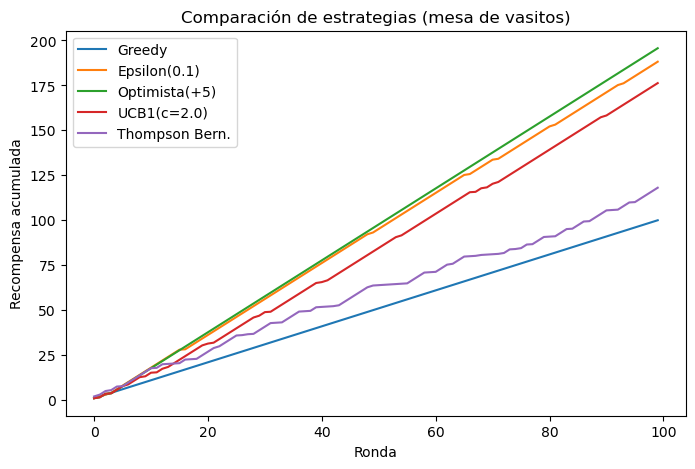

In [274]:
import matplotlib.pyplot as plt
import numpy as np

# --- utilidades ---
def clonar_mesa(vasitos_base, rondas):
    # Crea nuevos objetos Vasito para no compartir estado entre estrategias
    vasos = [Vasito(v.color, v.reward) for v in vasitos_base]
    return Mesa(vasos, rondas=rondas)

def jugar_y_trazar(mesa, jugador):
    """Devuelve lista con recompensa acumulada por ronda."""
    acumulado = []
    while not mesa.terminado():
        jugador.jugar_una_ronda(mesa)
        acumulado.append(jugador.recompensa_total)
    return np.array(acumulado)

# --- define tu “feria” (mesa base) ---
vasitos_base = [
    Vasito("rojo", 1.0),
    Vasito("azul", 0.5),
    Vasito("negro", 2.0),
    Vasito("verde", 0.2),
]
RONDAS = 100

# --- estrategias a comparar ---
estrategias = {
    "Greedy":           lambda: Greedy(),
    "Epsilon(0.1)":     lambda: EpsilonGreedy(epsilon=0.1, seed=42),
    "Optimista(+5)":    lambda: OptimisticGreedy(valor_inicial=500),
    "UCB1(c=2.0)":      lambda: UCB1(c=2.0),
    "Thompson Bern.":   lambda: ThompsonBernoulli(seed=0),  # ideal si recompensas 0/1
}

# --- jugar y recolectar trazas ---
trazas = {}
for nombre, make_strat in estrategias.items():
    mesa = clonar_mesa(vasitos_base, RONDAS)
    jugador = Jugador(make_strat(), nombre=f"J-{nombre}")
    traza = jugar_y_trazar(mesa, jugador)
    trazas[nombre] = traza

# --- graficar: recompensa acumulada por ronda ---
plt.figure(figsize=(8,5))
for nombre, traza in trazas.items():
    plt.plot(traza, label=nombre)
plt.xlabel("Ronda")
plt.ylabel("Recompensa acumulada")
plt.title("Comparación de estrategias (mesa de vasitos)")
plt.legend()
plt.show()


Veamos ahora vasitos normales.

In [275]:
class VasitoNormal:
    def __init__(self, color: str, mu: float, sigma: float = 1.0, rng=None):
        """
        mu: media de la recompensa
        sigma: desviación estándar
        """
        self.color = color
        self.mu = mu
        self.sigma = sigma
        self.rng = np.random.default_rng() if rng is None else rng

    def dar_recompensa(self) -> float:
        """Devuelve una muestra de N(mu, sigma^2)."""
        return float(self.rng.normal(self.mu, self.sigma))

    def __repr__(self):
        return f"VasitoNormal(color={self.color}, mu={self.mu}, sigma={self.sigma})"



In [276]:
class ThompsonNormal(Estrategia):
    def __init__(self, sigma: float = 1.0, mu0: float = 0.0, tau0: float = 1.0, seed=None):
        """
        sigma: desviación estándar conocida de las recompensas
        mu0: media inicial del prior
        tau0: precisión inicial del prior (1/varianza)
        """
        self.sigma = sigma
        self.mu0 = mu0
        self.tau0 = tau0
        self.rng = np.random.default_rng(seed)
        self.n = {}
        self.sum_x = {}

    def _init(self, mesa: "Mesa"):
        if not self.n:
            for color in mesa.colores_disponibles():
                self.n[color] = 0
                self.sum_x[color] = 0.0

    def decidir(self, mesa: "Mesa") -> str:
        self._init(mesa)
        muestras = {}
        for color in mesa.colores_disponibles():
            n = self.n[color]
            sum_x = self.sum_x[color]
            # Posterior para la media de una normal con varianza conocida
            mu_post = (self.tau0 * self.mu0 + sum_x) / (self.tau0 + n)
            tau_post = self.tau0 + n
            sigma_post = self.sigma / np.sqrt(tau_post)
            muestras[color] = self.rng.normal(mu_post, sigma_post)
        return max(muestras, key=muestras.get)

    def actualizar(self, eleccion, recompensa: float):
        color = eleccion.color if hasattr(eleccion, "color") else eleccion
        self.n[color] += 1
        self.sum_x[color] += recompensa


In [277]:
# Definimos vasitos con medias distintas
vasitos_base = [
    VasitoNormal("rojo", mu=1.0, sigma=3),
    VasitoNormal("azul", mu=0.5, sigma=10.0),
    VasitoNormal("negro", mu=2.0, sigma=1.0),
    VasitoNormal("verde", mu=0.2, sigma=5),
]

RONDAS = 100

# Estrategias a comparar
estrategias = {
    "Greedy":           lambda: Greedy(),
    "Epsilon(0.1)":     lambda: EpsilonGreedy(epsilon=0.1, seed=42),
    "Optimista(+5)":    lambda: OptimisticGreedy(valor_inicial=5),
    "UCB1(c=2.0)":      lambda: UCB1(c=2.0),
    "Thompson Normal":  lambda: ThompsonNormal(sigma=1.0, seed=0),
}


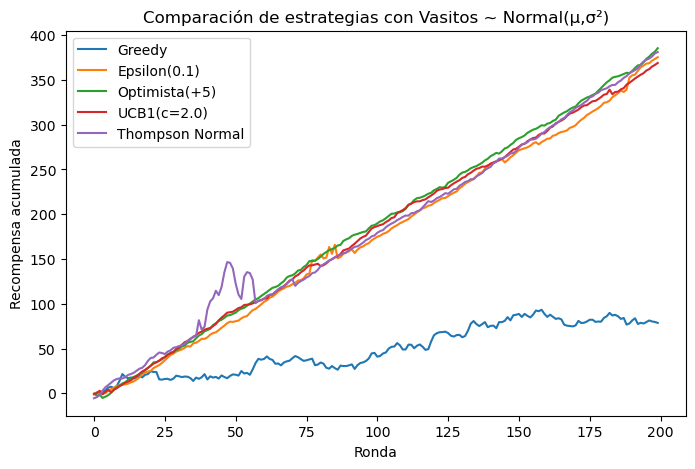

In [285]:
# --- utilidades ---
def clonar_mesa(vasitos_base, rondas):
    # Crear nuevos VasitoNormal (para no compartir RNG entre estrategias)
    vasos = [VasitoNormal(v.color, v.mu, v.sigma) for v in vasitos_base]
    return Mesa(vasos, rondas=rondas)

def jugar_y_trazar(mesa, jugador):
    """Devuelve lista con recompensa acumulada por ronda."""
    acumulado = []
    while not mesa.terminado():
        jugador.jugar_una_ronda(mesa)
        acumulado.append(jugador.recompensa_total)
    return np.array(acumulado)

# --- correr todas las estrategias ---
trazas = {}
for nombre, make_strat in estrategias.items():
    mesa = clonar_mesa(vasitos_base, RONDAS)
    jugador = Jugador(make_strat(), nombre=f"J-{nombre}")
    traza = jugar_y_trazar(mesa, jugador)
    trazas[nombre] = traza

# --- graficar ---
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for nombre, traza in trazas.items():
    plt.plot(traza, label=nombre)
plt.xlabel("Ronda")
plt.ylabel("Recompensa acumulada")
plt.title("Comparación de estrategias con Vasitos ~ Normal(μ,σ²)")
plt.legend()
plt.show()


In [279]:
import numpy as np
import matplotlib.pyplot as plt

# ===== utilidades =====
def clonar_mesa_normales(vasitos_base, rondas):
    """Clona vasitos normales para no compartir RNG/estado entre estrategias."""
    vasos = [VasitoNormal(v.color, v.mu, v.sigma) for v in vasitos_base]
    return Mesa(vasos, rondas=rondas)

def run_una_vez(vasitos_base, rondas, make_strategy):
    mesa = clonar_mesa_normales(vasitos_base, rondas)
    jugador = Jugador(make_strategy())
    rewards = np.zeros(rondas, dtype=float)
    t = 0
    while not mesa.terminado():
        r = jugador.jugar_una_ronda(mesa)
        rewards[t] = r
        t += 1
    return rewards  # recompensa en cada ronda (no acumulada)

def eval_promedio(vasitos_base, rondas, estrategias, runs=200, seed=123):
    rng = np.random.default_rng(seed)
    resultados = {}
    for nombre, make_strat in estrategias.items():
        R = np.zeros((runs, rondas), dtype=float)
        for i in range(runs):
            # semilla distinta por run si tu estrategia la usa
            strat = lambda: make_strat(rng.integers(0, 10_000))
            # si la estrategia no acepta seed, iguaaal funciona: make_strat ignora el arg
            R[i] = run_una_vez(vasitos_base, rondas, strat)
        resultados[nombre] = {
            "mean": R.mean(axis=0),
            "stderr": R.std(axis=0, ddof=1) / np.sqrt(runs),
        }
    return resultados

def plot_promedio(resultados, title="Recompensa promedio por ronda (±EE)"):
    plt.figure(figsize=(9,5))
    for nombre, stats in resultados.items():
        m, se = stats["mean"], stats["stderr"]
        x = np.arange(1, len(m)+1)
        plt.plot(x, m, label=nombre)
        plt.fill_between(x, m - se, m + se, alpha=0.15)
    plt.xlabel("Ronda")
    plt.ylabel("Recompensa promedio")
    plt.title(title)
    plt.legend()
    plt.show()


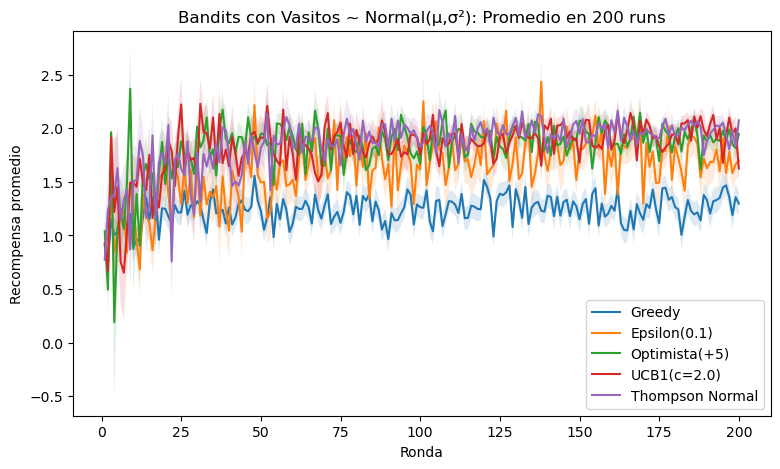

In [281]:
# ===== define el entorno de vasitos normales =====
vasitos_base = [
    VasitoNormal("rojo",  mu=1.0, sigma=1.5),
    VasitoNormal("azul",  mu=0.5, sigma=3.0),
    VasitoNormal("negro", mu=2.0, sigma=1.0),  # mejor media
    VasitoNormal("verde", mu=0.2, sigma=10.0),
]
RONDAS = 200

# ===== estrategias a comparar =====
# Nota: para permitir reproducibilidad por run, cada factory acepta un 'seed_run'
estrategias = {
    "Greedy":            lambda seed_run=None: Greedy(),
    "Epsilon(0.1)":      lambda seed_run=None: EpsilonGreedy(epsilon=0.1, seed=seed_run),
    "Optimista(+5)":     lambda seed_run=None: OptimisticGreedy(valor_inicial=5.0),
    "UCB1(c=2.0)":       lambda seed_run=None: UCB1(c=2.0),
    "Thompson Normal":   lambda seed_run=None: ThompsonNormal(sigma=1.0, seed=seed_run),
}

# ===== correr muchas corridas y graficar =====
resultados = eval_promedio(vasitos_base, RONDAS, estrategias, runs=200, seed=2025)
plot_promedio(resultados, title="Bandits con Vasitos ~ Normal(μ,σ²): Promedio en 200 runs")



No estacionario

In [287]:
from typing import Optional, Dict

class MesaNoEstacionaria(Mesa):
    """
    Mesa no estacionaria:
    - Tras cada ronda, actualiza las medias mu de los vasitos con un random walk ~ N(0, walk_std).
    - 'schedule' opcional: diccionario {ronda: {color: nueva_mu}} que aplica cambios discretos
      DESPUÉS de completar esa ronda (es decir, afecta desde la siguiente).
    """
    def __init__(
        self,
        vasitos: list,
        rondas: int = 100,
        walk_std: float = 0.02,
        schedule: Optional[Dict[int, Dict[str, float]]] = None,
        rng=None
    ):
        super().__init__(vasitos, rondas)
        self.walk_std = float(walk_std)
        self.schedule = schedule or {}   # {ronda: {color: nueva_mu}}
        self.rng = np.random.default_rng() if rng is None else rng

    def _aplicar_schedule_si_corresponde(self):
        # Se evalúa con ronda_actual ya incrementada por super().jugar(...)
        if self.ronda_actual in self.schedule:
            cambios = self.schedule[self.ronda_actual]
            for v in self.vasitos:
                if v.color in cambios and hasattr(v, "mu"):
                    v.mu = float(cambios[v.color])

    def _random_walk_en_todos(self):
        for v in self.vasitos:
            if hasattr(v, "mu"):
                v.mu += float(self.rng.normal(0.0, self.walk_std))

    def jugar(self, eleccion) -> float:
        # Juega la ronda normal (incrementa ronda_actual y registra historial)
        recompensa = super().jugar(eleccion)
        # Luego aplica dinámica no estacionaria (cambios discretos + drift)
        self._aplicar_schedule_si_corresponde()
        self._random_walk_en_todos()
        return recompensa


In [288]:
vasitos_base = [
    VasitoNormal("rojo",  mu=1.0),
    VasitoNormal("azul",  mu=0.5),
    VasitoNormal("negro", mu=2.0),
    VasitoNormal("verde", mu=0.2),
]

# Cambio programado: al terminar la ronda 50, 'azul' pasa a mu=2.2 y 'negro' a 0.5
schedule = {50: {"azul": 2.2, "negro": 0.5}}

mesa_ns = MesaNoEstacionaria(vasitos_base, rondas=100, walk_std=0.03, schedule=schedule)
estrategia = EpsilonGreedy(epsilon=0.1, alpha=0.1, seed=42)  # α fijo para no estacionario
jugador = Jugador(estrategia, nombre="NS-Player")

total = jugador.jugar_hasta_terminar(mesa_ns)
print("Total:", total)


Total: 105.39733899574634
